In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from skimage.io import imread
from skimage.transform import resize
from time import time
from typing import Callable, Optional

In [17]:
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")

In [3]:
images = []
lesions = []
path = os.path.join(os.getcwd(), "data", "PH2 Dataset images")
for root, dirs, files in os.walk(path):
    if root.endswith("_Dermoscopic_Image"):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith("_lesion"):
        lesions.append(imread(os.path.join(root, files[0])))
size = (256, 256)
X = [
    resize(
        x,
        size,
        mode="constant",
        anti_aliasing=True,
    )
    for x in images
]
Y = [resize(y, size, mode="constant", anti_aliasing=False) > 0.5 for y in lesions]
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f"Loaded {len(X)} images")
ix = np.random.choice(len(X), len(X), False)
train_set, value_set, test_set = np.split(ix, [100, 150])
print(len(train_set), len(value_set), len(test_set))

Loaded 200 images
100 50 50


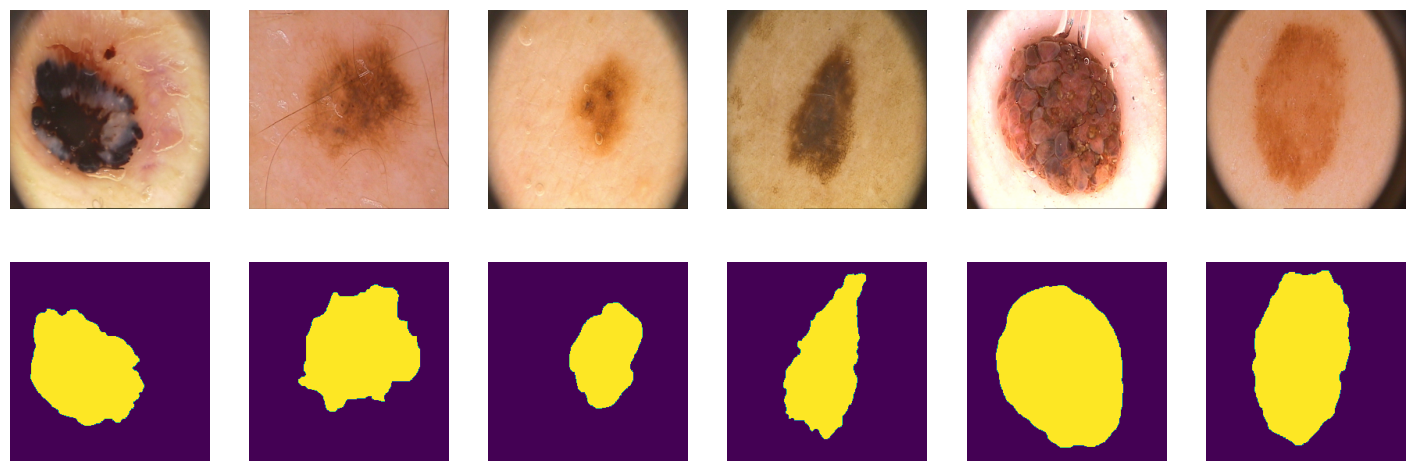

In [4]:
def plot_images():
    plt.figure(figsize=(18, 6))
    for i in range(6):
        plt.subplot(2, 6, i + 1)
        plt.axis("off")
        plt.imshow(X[i])
        plt.subplot(2, 6, i + 7)
        plt.axis("off")
        plt.imshow(Y[i])
    plt.show()


plot_images()

In [5]:
batch_size = 16
train_loader = DataLoader(
    list(zip(np.rollaxis(X[train_set], 3, 1), Y[train_set, np.newaxis])),
    batch_size=batch_size,
    shuffle=True,
)

validation_loader = DataLoader(
    list(zip(np.rollaxis(X[value_set], 3, 1), Y[value_set, np.newaxis])),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    list(zip(np.rollaxis(X[test_set], 3, 1), Y[test_set, np.newaxis])),
    batch_size=batch_size,
    shuffle=False,
)

In [6]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    smooth = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + smooth) / (union + smooth)
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    return thresholded

In [7]:
def score_model(
    _model: nn.Module, _metric: Callable, _data_loader: DataLoader
) -> float:
    _model.eval()
    scores = 0
    threshold = 0.5
    for images, labels in _data_loader:
        outputs = _model(images.to(DEVICE))
        outputs = (outputs > threshold).float()
        scores += _metric(outputs, labels.to(DEVICE)).mean().item()
    return scores / len(_data_loader)


def show_images(x_val, y_val, y_hat, epoch, epochs, avg_loss):
    for k in range(6):
        plt.subplot(3, 6, k + 1)
        plt.imshow(np.rollaxis(x_val[k].numpy(), 0, 3), cmap="gray")
        plt.title("Image")
        plt.axis("off")
        plt.subplot(3, 6, k + 7)
        plt.imshow(y_val[k, 0], cmap="gray")
        plt.title("Labels")
        plt.axis("off")
        plt.subplot(3, 6, k + 13)
        plt.imshow(np.round(y_hat[k, 0].numpy()), cmap="gray")
        plt.title("Predicted")
        plt.axis("off")
    plt.suptitle("%d / %d - loss: %f" % (epoch, epochs, avg_loss))
    plt.show()

In [14]:
def train(
    _model: nn.Module,
    _optimizer: torch.optim.Optimizer,
    _loss_func: nn.Module,
    epochs: int,
    _train_loader: DataLoader,
    _validation_loader: DataLoader,
    _scheduler: Optional[torch.optim.lr_scheduler.ExponentialLR] = None,
):
    x_val, y_val = next(iter(_validation_loader))
    start_time = time()
    for epoch in range(epochs):
        train_avg_loss = 0
        validation_avg_loss = 0
        _model.train()  # train mode
        for images, labels in _train_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            _optimizer.zero_grad()
            outputs = _model(images)
            loss = _loss_func(outputs, labels)
            loss.backward()
            _optimizer.step()
            train_avg_loss += loss / len(_train_loader)
        _model.eval()
        # validation mode
        for X_batch2, Y_batch2 in _validation_loader:
            inputs2 = X_batch2.to(DEVICE)
            y_pred2 = _model(inputs2).cpu().detach()
            validation_loss = _loss_func(y_pred2, Y_batch2)
            validation_avg_loss += validation_loss / len(_validation_loader)

        if _scheduler is not None:
            _scheduler.step()
            print(f"Learning rate: {_scheduler.get_last_lr()}")

        train_score = score_model(_model, iou_pytorch, _train_loader)
        validation_score = score_model(_model, iou_pytorch, _validation_loader)
        print(
            "Epoch: %d/%d, train loss: %f, validation loss: %f, train score: %f, validation score: %f"
            % (
                epoch + 1,
                epochs,
                train_avg_loss,
                validation_avg_loss,
                train_score,
                validation_score,
            )
        )
        if epoch + 1 == epochs:
            y_hat = _model(x_val.to(DEVICE)).detach().to("cpu")
            show_images(x_val, y_val, y_hat, epoch + 1, epochs, train_avg_loss)
    print("Elapsed time: %s" % np.round((time() - start_time), 1))

In [11]:
from unet_model import UNet
max_epochs = 50

Epoch: 1/50, train loss: 0.669192, validation loss: 0.691602, train score: 0.000000, validation score: 0.000000
Epoch: 2/50, train loss: 0.617713, validation loss: 0.685619, train score: 0.000000, validation score: 0.000000
Epoch: 3/50, train loss: 0.567096, validation loss: 0.658125, train score: 0.000000, validation score: 0.000000
Epoch: 4/50, train loss: 0.543097, validation loss: 0.620535, train score: 0.000000, validation score: 0.037500
Epoch: 5/50, train loss: 0.517064, validation loss: 0.615313, train score: 0.083929, validation score: 0.079688
Epoch: 6/50, train loss: 0.490000, validation loss: 0.512198, train score: 0.205357, validation score: 0.235938
Epoch: 7/50, train loss: 0.472232, validation loss: 0.454340, train score: 0.283036, validation score: 0.290625
Epoch: 8/50, train loss: 0.440622, validation loss: 0.410834, train score: 0.425000, validation score: 0.442188
Epoch: 9/50, train loss: 0.431075, validation loss: 0.445559, train score: 0.575000, validation score: 0

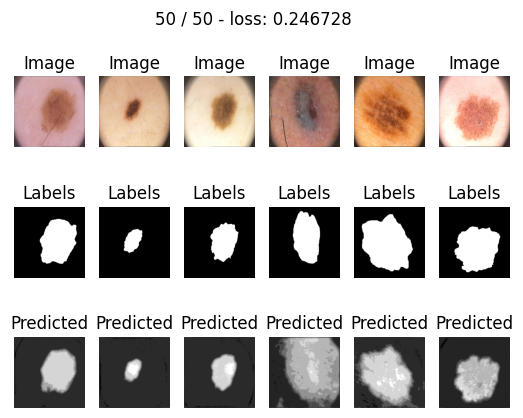

Elapsed time: 991.7
0.78125


In [38]:
def train_unet():
    model = UNet(n_channels=3, n_classes=1)
    model.to(DEVICE)
    loss_function = nn.BCEWithLogitsLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
    train(model, optim, loss_function, max_epochs, train_loader, validation_loader)
    final_score = score_model(model, iou_pytorch, validation_loader)
    print(final_score)


train_unet()

Learning rate: [0.0009000000000000001]
Epoch: 1/50, train loss: 0.427346, validation loss: 0.630021, train score: 0.000000, validation score: 0.000000
Learning rate: [0.0008100000000000001]
Epoch: 2/50, train loss: 0.289433, validation loss: 1.999483, train score: 0.241071, validation score: 0.232813
Learning rate: [0.000729]
Epoch: 3/50, train loss: 0.304452, validation loss: 0.845100, train score: 0.036607, validation score: 0.006250
Learning rate: [0.0006561000000000001]
Epoch: 4/50, train loss: 0.248880, validation loss: 0.385463, train score: 0.198214, validation score: 0.131250
Learning rate: [0.00059049]
Epoch: 5/50, train loss: 0.231866, validation loss: 0.332754, train score: 0.303571, validation score: 0.350000
Learning rate: [0.000531441]
Epoch: 6/50, train loss: 0.233403, validation loss: 0.287878, train score: 0.491964, validation score: 0.503125
Learning rate: [0.0004782969]
Epoch: 7/50, train loss: 0.212894, validation loss: 0.265019, train score: 0.514286, validation sc

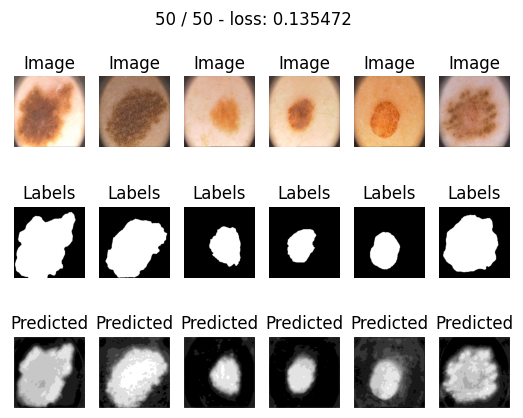

Elapsed time: 982.4
0.6906249970197678


In [18]:
def train_with_scheduler():
    model = UNet(n_channels=3, n_classes=1)
    model.to(DEVICE)
    loss_function = nn.BCEWithLogitsLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=0.0000001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=1.1)
    train(model, optim, loss_function, max_epochs, train_loader, validation_loader, scheduler)
    final_score = score_model(model, iou_pytorch, validation_loader)
    print(final_score)

train_with_scheduler()

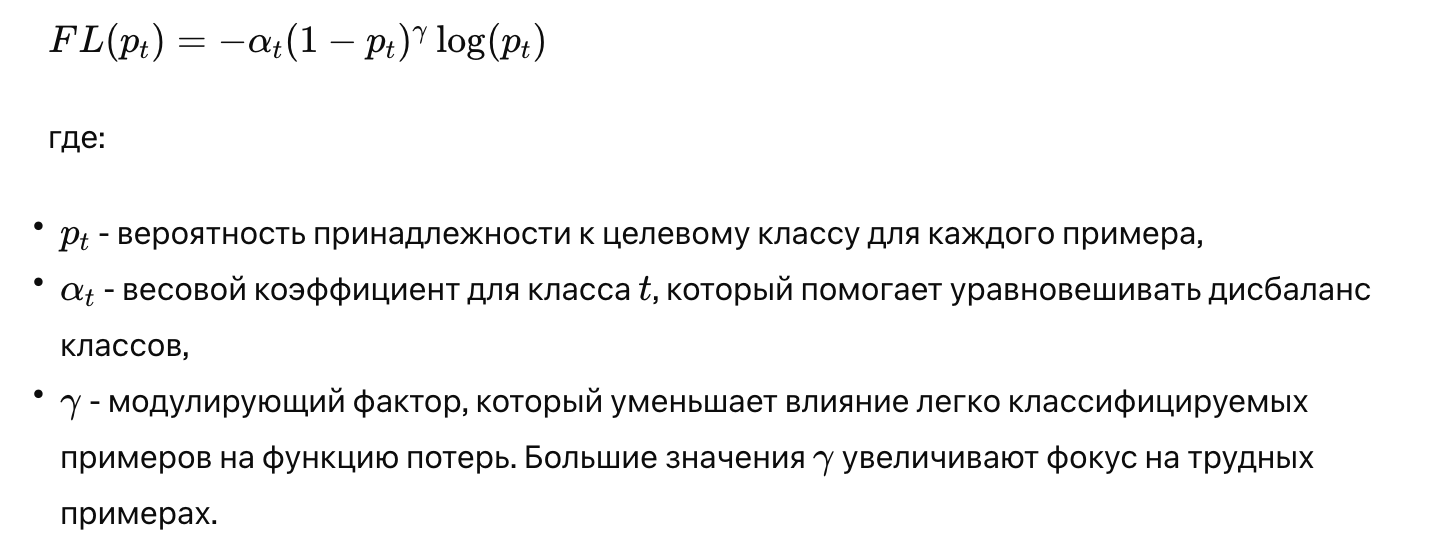
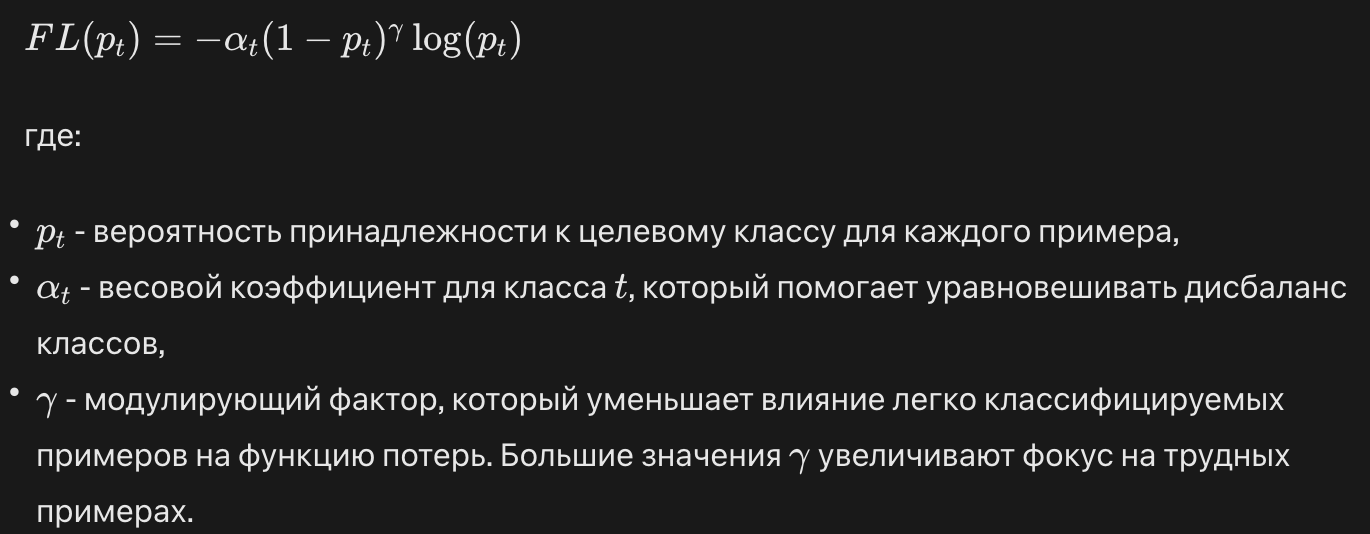

Epoch: 1/50, train loss: 0.158385, validation loss: 0.148913, train score: 0.000000, validation score: 0.000000
Epoch: 2/50, train loss: 0.132298, validation loss: 0.149050, train score: 0.000000, validation score: 0.000000
Epoch: 3/50, train loss: 0.110011, validation loss: 0.151693, train score: 0.000000, validation score: 0.000000
Epoch: 4/50, train loss: 0.094098, validation loss: 0.135254, train score: 0.000000, validation score: 0.000000
Epoch: 5/50, train loss: 0.086403, validation loss: 0.112482, train score: 0.047321, validation score: 0.018750
Epoch: 6/50, train loss: 0.078490, validation loss: 0.090589, train score: 0.171429, validation score: 0.139062
Epoch: 7/50, train loss: 0.070818, validation loss: 0.075131, train score: 0.278571, validation score: 0.270313
Epoch: 8/50, train loss: 0.063296, validation loss: 0.065504, train score: 0.381250, validation score: 0.318750
Epoch: 9/50, train loss: 0.066104, validation loss: 0.060079, train score: 0.492857, validation score: 0

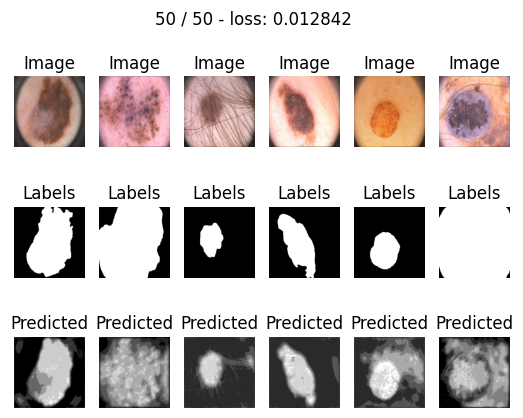

Elapsed time: 975.9
0.6234375014901161


In [12]:
from losses import FocalLoss


def train_with_focal():
    model = UNet(n_channels=3, n_classes=1)
    model.to(DEVICE)
    loss_function = FocalLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
    train(model, optim, loss_function, max_epochs, train_loader, validation_loader)
    final_score = score_model(model, iou_pytorch, validation_loader)
    print(final_score)


train_with_focal()

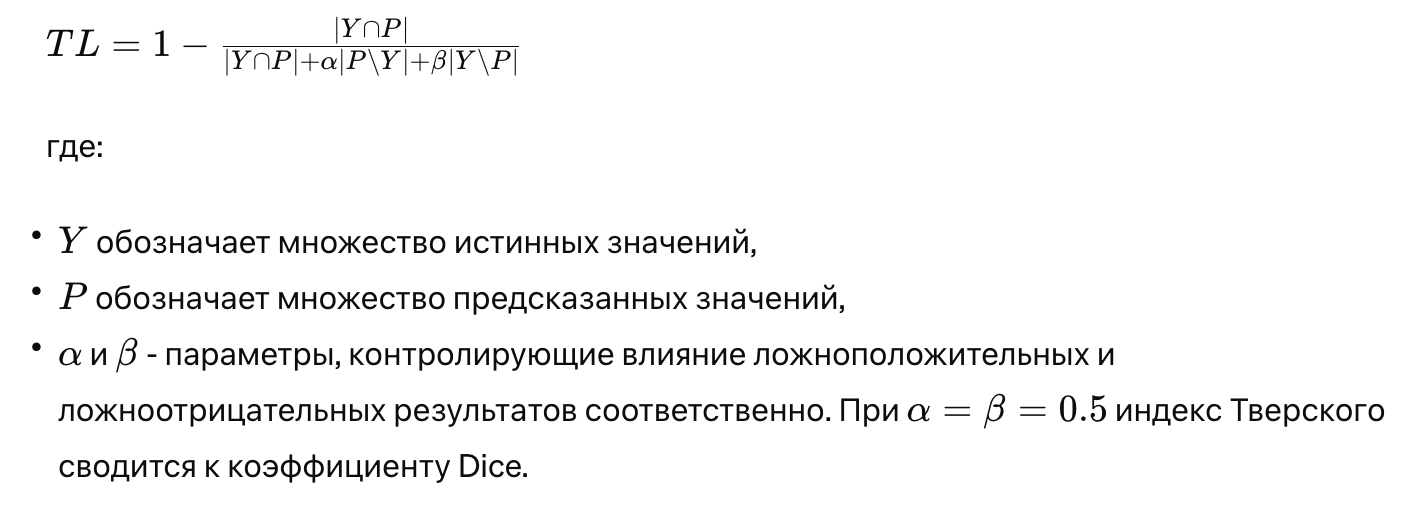
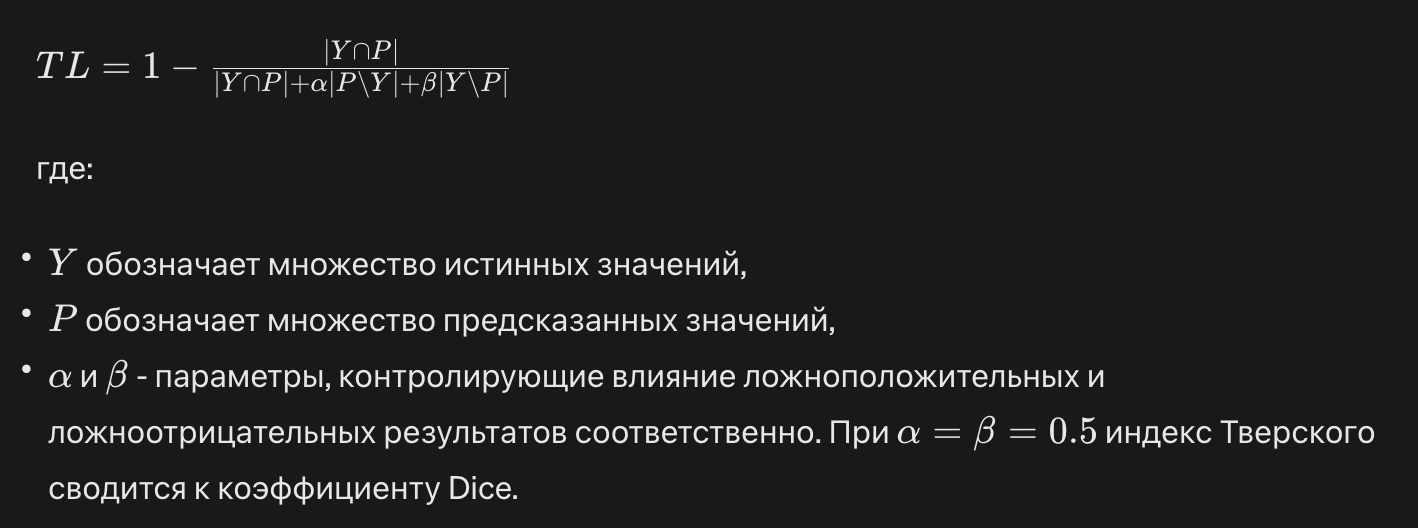

Epoch: 1/50, train loss: 0.646910, validation loss: 0.599837, train score: 0.000000, validation score: 0.000000
Epoch: 2/50, train loss: 0.611503, validation loss: 0.625930, train score: 0.000000, validation score: 0.000000
Epoch: 3/50, train loss: 0.575596, validation loss: 0.617570, train score: 0.000000, validation score: 0.000000
Epoch: 4/50, train loss: 0.523296, validation loss: 0.617283, train score: 0.000000, validation score: 0.000000
Epoch: 5/50, train loss: 0.503741, validation loss: 0.614003, train score: 0.000000, validation score: 0.000000
Epoch: 6/50, train loss: 0.468080, validation loss: 0.548801, train score: 0.005357, validation score: 0.003125
Epoch: 7/50, train loss: 0.468292, validation loss: 0.500795, train score: 0.187500, validation score: 0.151563
Epoch: 8/50, train loss: 0.440529, validation loss: 0.506033, train score: 0.329464, validation score: 0.226562
Epoch: 9/50, train loss: 0.412624, validation loss: 0.438404, train score: 0.456250, validation score: 0

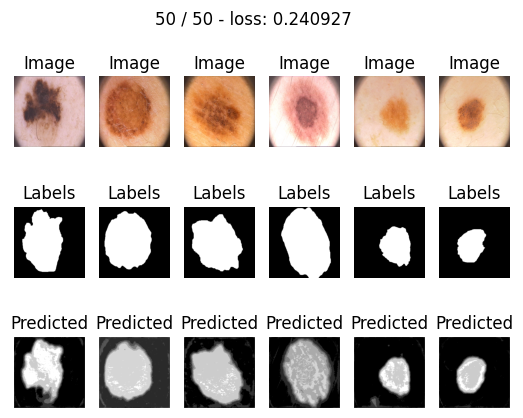

Elapsed time: 978.9
0.6703125014901161


In [19]:
from losses import TverskyLoss


def train_with_tversky():
    model = UNet(n_channels=3, n_classes=1)
    model.to(DEVICE)
    loss_function = TverskyLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
    train(model, optim, loss_function, max_epochs, train_loader, validation_loader)
    final_score = score_model(model, iou_pytorch, validation_loader)
    print(final_score)


train_with_tversky()

https://github.com/vinceecws/SegNet_PyTorch
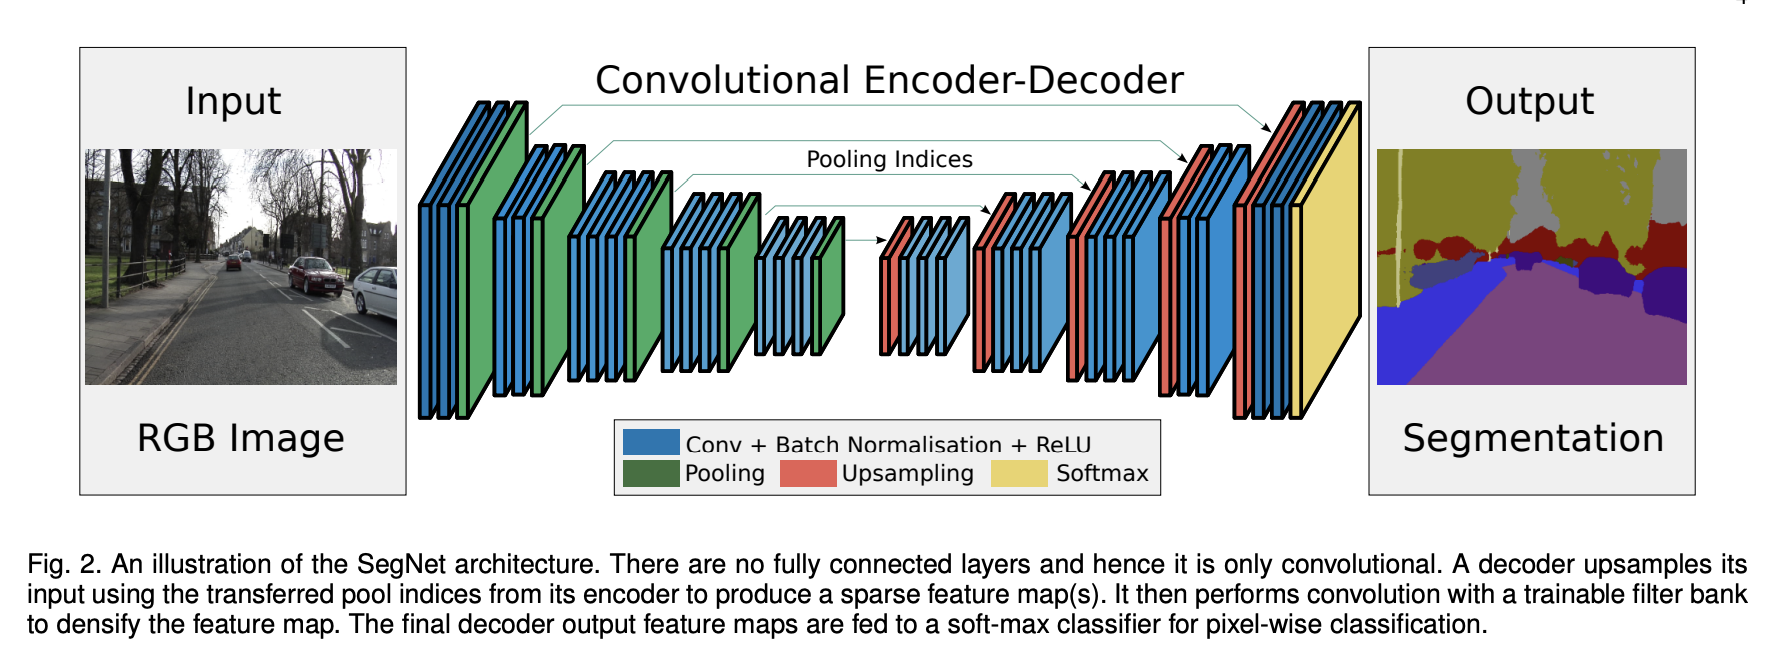

Epoch: 1/50, train loss: 0.765754, validation loss: 0.722640, train score: 0.000000, validation score: 0.000000
Epoch: 2/50, train loss: 0.723011, validation loss: 0.710639, train score: 0.056250, validation score: 0.029688
Epoch: 3/50, train loss: 0.697700, validation loss: 0.667119, train score: 0.095536, validation score: 0.107813
Epoch: 4/50, train loss: 0.663885, validation loss: 0.668976, train score: 0.132143, validation score: 0.131250
Epoch: 5/50, train loss: 0.640161, validation loss: 0.644739, train score: 0.100000, validation score: 0.112500
Epoch: 6/50, train loss: 0.616073, validation loss: 0.612829, train score: 0.290179, validation score: 0.318750
Epoch: 7/50, train loss: 0.587243, validation loss: 0.617952, train score: 0.121429, validation score: 0.148438
Epoch: 8/50, train loss: 0.571091, validation loss: 0.574987, train score: 0.495536, validation score: 0.435938
Epoch: 9/50, train loss: 0.555096, validation loss: 0.557799, train score: 0.484821, validation score: 0

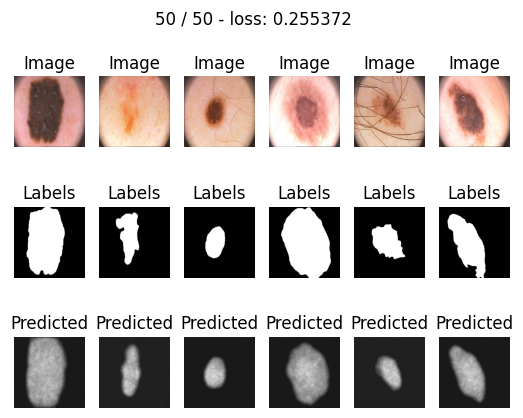

Elapsed time: 9875.2
0.5843750089406967


In [13]:
from segnet import SegNet

DEVICE = torch.device("cpu")


def train_segnet():
    model = SegNet()
    model.to(DEVICE)
    loss_function = nn.BCEWithLogitsLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=0.00001)
    train(model, optim, loss_function, max_epochs, train_loader, validation_loader)
    final_score = score_model(model, iou_pytorch, validation_loader)
    print(final_score)


train_segnet()

DEVICE = torch.device("mps")